# Super Resolution GAN - x0
## Phase 1: Deconstructing the SRGAN Paper

Before writing any code, it's crucial to understand the core components. A PhD student would first break down the paper into its constituent parts.
The Goal: The primary objective is <mark>to recover fine texture details in super-resolved images, making them look photo-realistic, even at high (4x) upscaling factors</mark>. The paper argues that traditional methods, which minimize Mean Squared Error (MSE), produce overly smooth and perceptually unsatisfying results.
- The Architecture: SRGAN is a Generative Adversarial Network with two key models:
    - Generator (G): A deep residual network (named SRResNet) that takes a Low-Resolution (LR) image and upscales it to a Super-Resolved (SR) image.
    - Discriminator (D): A convolutional neural network trained to distinguish between authentic High-Resolution (HR) images and fake SR images produced by the generator.
- The Innovation:
    - Perceptual Loss: This is the heart of the SRGAN. <mark>Instead of a simple pixel-wise MSE loss, the generator is trained with a perceptual loss (l_SR) which is a weighted sum of two components</mark>:
        - Content Loss (l_content):
            - This loss measures perceptual similarity, not pixel-wise similarity. It is calculated as the Euclidean distance between the feature representations of the generated image and the real image, extracted from a pre-trained VGG-19 network. The paper finds that using features from deeper layers (e.g., VGG54) produces better texture detail.
        - Adversarial Loss (l_adv):
            - This is the standard GAN loss that pushes the generator to create images that can "fool" the discriminator into thinking they are real.
- The Training Process: The paper proposes a two-stage training strategy for stability and better results:
    - Stage 1: Pre-training the Generator. The generator network (SRResNet) is first trained on its own using a pixel-wise MSE loss. This initializes the generator to produce plausible, albeit smooth, images with high PSNR (Peak Signal-to-Noise Ratio).
    - Stage 2: Adversarial Training. The pre-trained generator and the discriminator are then trained alternately. The generator's objective is now to minimize the combined perceptual loss, forcing it to learn realistic textures.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("takihasan/div2k-dataset-for-super-resolution")

print("Path to dataset files:", path)

100%|██████████| 4.94G/4.94G [00:32<00:00, 162MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/takihasan/div2k-dataset-for-super-resolution/versions/1


In [10]:
!ls /root/.cache/kagglehub/datasets/takihasan/div2k-dataset-for-super-resolution/versions/1/Dataset

DIV2K_train_HR		DIV2K_train_LR_bicubic_X4  DIV2K_valid_LR_bicubic
DIV2K_train_LR_bicubic	DIV2K_valid_HR		   DIV2K_valid_LR_bicubic_X4


## Config.py

In [ ]:
# config.py
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image

# --- Training Hyperparameters ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE_GEN = 1e-4
LEARNING_RATE_DISC = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS_PRETRAIN = 50
NUM_EPOCHS_GAN = 100
HIGH_RES_SIZE = 96  # As per the paper
LOW_RES_SIZE = HIGH_RES_SIZE // 4
NUM_WORKERS = 4
LAMBDA_VGG = 1.0  # Weight for VGG/content loss
LAMBDA_ADV = 1e-3  # Weight for adversarial loss

os.makedirs("saved_models", exist_ok=True)

# --- Model Paths ---
PRETRAINED_GEN_PATH = "saved_models/srresnet_pretrained.pth"
GEN_PATH = "saved_models/generator.pth"
DISC_PATH = "saved_models/discriminator.pth"

# --- Dataset Paths ---
TRAIN_DIR = "/root/.cache/kagglehub/datasets/takihasan/div2k-dataset-for-super-resolution/versions/1/Dataset/DIV2K_train_HR"
TEST_DIR = "/root/.cache/kagglehub/datasets/takihasan/div2k-dataset-for-super-resolution/versions/1/Dataset/DIV2K_valid_HR"

# set the repo name
model_name = "keanteng/srgan-div2k-0723-v2"

## Models.py

In [6]:
# models.py
import torch
from torch import nn

class ResidualBlock(nn.Module):
    """
    A single residual block as defined in the SRGAN paper.
    It contains two convolutional layers with batch normalization and PReLU activation.
    """
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
        )

    def forward(self, x):
        identity = x
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        return identity + out

class UpsampleBlock(nn.Module):
    """
    Upsampling block using a convolutional layer and PixelShuffle.
    This increases the resolution by a factor of 2.
    """
    def __init__(self, in_channels, scale_factor=2):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * (scale_factor ** 2), kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        return self.prelu(self.pixel_shuffle(self.conv(x)))

class Generator(nn.Module):
    """
    The Generator Network (SRResNet).
    It takes a low-resolution image and outputs a super-resolved version.
    """
    def __init__(self, in_channels=3, num_res_blocks=16):
        super(Generator, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )

        self.residuals = nn.Sequential(*[ResidualBlock(64) for _ in range(num_res_blocks)])

        self.mid_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        # Upsampling by 4x (two 2x upsample blocks)
        self.upsample_blocks = nn.Sequential(
            UpsampleBlock(64),
            UpsampleBlock(64),
        )

        self.final_conv = nn.Conv2d(64, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial_out = self.initial_conv(x)
        residual_out = self.residuals(initial_out)
        mid_out = self.mid_conv(residual_out)
        mid_out = mid_out + initial_out # Skip connection
        upsampled_out = self.upsample_blocks(mid_out)
        final_out = self.final_conv(upsampled_out)
        return torch.tanh(final_out) # Tanh activation to scale output to [-1, 1]

class Discriminator(nn.Module):
    """
    The Discriminator Network.
    It takes an image and outputs a probability of it being a real high-resolution image.
    """
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def conv_block(in_feat, out_feat, stride=1):
            return nn.Sequential(
                nn.Conv2d(in_feat, out_feat, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_feat),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            conv_block(64, 64, stride=2),
            conv_block(64, 128, stride=1),
            conv_block(128, 128, stride=2),
            conv_block(128, 256, stride=1),
            conv_block(256, 256, stride=2),
            conv_block(256, 512, stride=1),
            conv_block(512, 512, stride=2),
        )

        # The paper mentions flattening and then two dense layers
        # The output size after convolutions on a 96x96 image is 512x6x6
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Flattens the output
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        out = self.blocks(x)
        out = self.classifier(out)
        return out.view(batch_size, -1) # No sigmoid here, handled by BCEWithLogitsLoss

## Loss.py

In [7]:
# loss.py
import torch
from torch import nn
from torchvision.models import vgg19

class VGGContentLoss(nn.Module):
    """
    Calculates the content loss in the VGG19 feature space.
    The paper uses the features from the layer before the 5th max-pooling layer (VGG54).
    In PyTorch's VGG19 implementation, this corresponds to `features[35]`.
    """
    def __init__(self, device):
        super(VGGContentLoss, self).__init__()
        vgg_model = vgg19(weights="DEFAULT").features[:36].to(device).eval()
        for param in vgg_model.parameters():
            param.requires_grad = False
        self.vgg_model = vgg_model
        self.loss = nn.MSELoss()

    def forward(self, generated, target):
        gen_features = self.vgg_model(generated)
        target_features = self.vgg_model(target)
        return self.loss(gen_features, target_features)

class PerceptualLoss(nn.Module):
    """
    Combined Perceptual Loss for SRGAN training.
    It includes VGG content loss and adversarial loss.
    """
    def __init__(self, device, lambda_vgg, lambda_adv):
        super(PerceptualLoss, self).__init__()
        self.vgg_loss_fn = VGGContentLoss(device)
        self.adversarial_loss_fn = nn.BCEWithLogitsLoss()
        self.lambda_vgg = lambda_vgg
        self.lambda_adv = lambda_adv

    def forward(self, disc_fake_output, gen_hr, hr_img):
        # Content Loss
        vgg_loss = self.vgg_loss_fn(gen_hr, hr_img)

        # Adversarial Loss (Generator's perspective)
        # We want the generator to fool the discriminator, so we compare its output to a tensor of ones.
        adversarial_loss = self.adversarial_loss_fn(disc_fake_output, torch.ones_like(disc_fake_output))

        # Total Perceptual Loss
        total_loss = self.lambda_vgg * vgg_loss + self.lambda_adv * adversarial_loss
        return total_loss

## Dataset.py

In [ ]:
# dataset.py
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    """
    Custom dataset to load high-resolution images and create low-resolution counterparts.
    """
    def __init__(self, hr_dir, hr_size):
        super(ImageDataset, self).__init__()
        self.hr_image_files = [os.path.join(hr_dir, f) for f in os.listdir(hr_dir)]
        self.hr_size = hr_size

        # Transform for the original image before cropping
        self.initial_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        # Normalization transforms
        self.hr_normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        self.lr_normalize = transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])

        # Apply the same normalization to both HR and LR images
        # transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        # ])

        # hr_normalized = transform(hr_cropped)
        # lr_normalized = transform(lr_tensor)

    def __getitem__(self, index):
        # Load image
        hr_image = Image.open(self.hr_image_files[index]).convert("RGB")

        # Convert to tensor first
        hr_tensor = self.initial_transform(hr_image)

        # Apply random crop to get consistent size
        crop_transform = transforms.RandomCrop(self.hr_size)
        hr_cropped = crop_transform(hr_tensor)

        # Create LR version by downsampling the cropped HR image
        lr_tensor = transforms.functional.resize(
            hr_cropped,
            size=self.hr_size // 4,
            interpolation=transforms.InterpolationMode.BICUBIC
        )

        # Apply normalization
        hr_normalized = self.hr_normalize(hr_cropped)
        lr_normalized = self.lr_normalize(lr_tensor)

        return lr_normalized, hr_normalized

    def __len__(self):
        return len(self.hr_image_files)

## Pretraining.py

In [15]:
# train_srresnet.py
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from tqdm import tqdm
#import config
#from models import Generator
#from dataset import ImageDataset

def train_srresnet():
    dataset = ImageDataset(hr_dir=TRAIN_DIR, hr_size=HIGH_RES_SIZE)
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    gen = Generator().to(DEVICE)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE_GEN)
    mse_loss = nn.MSELoss()

    gen.train()

    print("--- Starting SRResNet Pre-training ---")
    for epoch in range(NUM_EPOCHS_PRETRAIN):
        loop = tqdm(loader, leave=True)
        total_loss = 0
        for lr, hr in loop:
            lr = lr.to(DEVICE)
            hr = hr.to(DEVICE)

            gen_hr = gen(lr)
            loss = mse_loss(gen_hr, hr)

            opt_gen.zero_grad()
            loss.backward()
            opt_gen.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(loader)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PRETRAIN}] - Avg Loss: {avg_loss:.4f}")

        torch.save(gen.state_dict(), PRETRAINED_GEN_PATH)
    print("--- Finished SRResNet Pre-training ---")

if __name__ == "__main__":
    train_srresnet()

--- Starting SRResNet Pre-training ---


100%|██████████| 50/50 [00:24<00:00,  2.03it/s, loss=0.0504]


Epoch [1/15] - Avg Loss: 0.1194


100%|██████████| 50/50 [00:25<00:00,  1.93it/s, loss=0.0729]


Epoch [2/15] - Avg Loss: 0.0662


100%|██████████| 50/50 [00:25<00:00,  1.93it/s, loss=0.0376]


Epoch [3/15] - Avg Loss: 0.0558


100%|██████████| 50/50 [00:25<00:00,  1.98it/s, loss=0.0367]


Epoch [4/15] - Avg Loss: 0.0487


100%|██████████| 50/50 [00:25<00:00,  1.98it/s, loss=0.0322]


Epoch [5/15] - Avg Loss: 0.0414


100%|██████████| 50/50 [00:26<00:00,  1.88it/s, loss=0.0239]


Epoch [6/15] - Avg Loss: 0.0373


100%|██████████| 50/50 [00:25<00:00,  1.99it/s, loss=0.0181]


Epoch [7/15] - Avg Loss: 0.0318


100%|██████████| 50/50 [00:25<00:00,  1.96it/s, loss=0.0205]


Epoch [8/15] - Avg Loss: 0.0286


100%|██████████| 50/50 [00:26<00:00,  1.92it/s, loss=0.0354]


Epoch [9/15] - Avg Loss: 0.0300


100%|██████████| 50/50 [00:24<00:00,  2.00it/s, loss=0.0281]


Epoch [10/15] - Avg Loss: 0.0285


100%|██████████| 50/50 [00:25<00:00,  1.94it/s, loss=0.0207]


Epoch [11/15] - Avg Loss: 0.0258


100%|██████████| 50/50 [00:25<00:00,  1.97it/s, loss=0.0238]


Epoch [12/15] - Avg Loss: 0.0247


100%|██████████| 50/50 [00:25<00:00,  1.97it/s, loss=0.0241]


Epoch [13/15] - Avg Loss: 0.0265


100%|██████████| 50/50 [00:23<00:00,  2.10it/s, loss=0.0253]


Epoch [14/15] - Avg Loss: 0.0230


100%|██████████| 50/50 [00:25<00:00,  1.96it/s, loss=0.0221]

Epoch [15/15] - Avg Loss: 0.0227
--- Finished SRResNet Pre-training ---


## Adversarial.py

In [16]:
# train_gan.py
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from tqdm import tqdm
#import config
#from models import Generator, Discriminator
#from dataset import ImageDataset
#from loss import PerceptualLoss

def train_gan():
    dataset = ImageDataset(hr_dir=TRAIN_DIR, hr_size=HIGH_RES_SIZE)
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    gen = Generator().to(DEVICE)
    disc = Discriminator().to(DEVICE)

    # Load pre-trained generator weights
    gen.load_state_dict(torch.load(PRETRAINED_GEN_PATH, map_location=DEVICE))

    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE_GEN, betas=(0.9, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE_DISC, betas=(0.9, 0.999))

    perceptual_loss_fn = PerceptualLoss(DEVICE, LAMBDA_VGG, LAMBDA_ADV)
    bce_loss = nn.BCEWithLogitsLoss()

    print("--- Starting SRGAN Training ---")
    for epoch in range(NUM_EPOCHS_GAN):
        gen.train()
        disc.train()
        loop = tqdm(loader, leave=True)

        for lr, hr in loop:
            lr = lr.to(DEVICE)
            hr = hr.to(DEVICE)

            # --- Train Discriminator ---
            gen_hr = gen(lr)

            disc_real_out = disc(hr)
            disc_fake_out = disc(gen_hr.detach())

            disc_loss_real = bce_loss(disc_real_out, torch.ones_like(disc_real_out))
            disc_loss_fake = bce_loss(disc_fake_out, torch.zeros_like(disc_fake_out))

            disc_loss = (disc_loss_real + disc_loss_fake) / 2

            opt_disc.zero_grad()
            disc_loss.backward()
            opt_disc.step()

            # --- Train Generator ---
            disc_fake_for_gen = disc(gen_hr)
            gen_loss = perceptual_loss_fn(disc_fake_for_gen, gen_hr, hr)

            opt_gen.zero_grad()
            gen_loss.backward()
            opt_gen.step()

            loop.set_postfix(g_loss=gen_loss.item(), d_loss=disc_loss.item())

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_GAN}]")
        torch.save(gen.state_dict(), GEN_PATH)
        torch.save(disc.state_dict(), DISC_PATH)

    print("--- Finished SRGAN Training ---")

if __name__ == "__main__":
    train_gan()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 232MB/s]


--- Starting SRGAN Training ---


100%|██████████| 50/50 [00:25<00:00,  1.95it/s, d_loss=0.288, g_loss=0.224]


Epoch [1/30]


100%|██████████| 50/50 [00:24<00:00,  2.00it/s, d_loss=0.0706, g_loss=0.236]


Epoch [2/30]


100%|██████████| 50/50 [00:25<00:00,  1.95it/s, d_loss=0.558, g_loss=0.221]


Epoch [3/30]


100%|██████████| 50/50 [00:25<00:00,  1.99it/s, d_loss=0.344, g_loss=0.246]


Epoch [4/30]


100%|██████████| 50/50 [00:26<00:00,  1.91it/s, d_loss=0.303, g_loss=0.238]


Epoch [5/30]


100%|██████████| 50/50 [00:25<00:00,  1.93it/s, d_loss=0.125, g_loss=0.185]


Epoch [6/30]


100%|██████████| 50/50 [00:25<00:00,  1.99it/s, d_loss=0.31, g_loss=0.315]


Epoch [7/30]


100%|██████████| 50/50 [00:25<00:00,  1.97it/s, d_loss=0.382, g_loss=0.179]


Epoch [8/30]


100%|██████████| 50/50 [00:25<00:00,  1.96it/s, d_loss=0.15, g_loss=0.202]


Epoch [9/30]


100%|██████████| 50/50 [00:26<00:00,  1.91it/s, d_loss=0.945, g_loss=0.261]


Epoch [10/30]


100%|██████████| 50/50 [00:25<00:00,  1.96it/s, d_loss=0.0418, g_loss=0.198]


Epoch [11/30]


100%|██████████| 50/50 [00:24<00:00,  2.02it/s, d_loss=0.135, g_loss=0.314]


Epoch [12/30]


100%|██████████| 50/50 [00:24<00:00,  2.04it/s, d_loss=0.0847, g_loss=0.173]


Epoch [13/30]


100%|██████████| 50/50 [00:25<00:00,  1.96it/s, d_loss=0.0637, g_loss=0.144]


Epoch [14/30]


100%|██████████| 50/50 [00:25<00:00,  1.96it/s, d_loss=0.0166, g_loss=0.11]


Epoch [15/30]


100%|██████████| 50/50 [00:25<00:00,  1.98it/s, d_loss=0.0105, g_loss=0.188]


Epoch [16/30]


100%|██████████| 50/50 [00:25<00:00,  1.99it/s, d_loss=0.0142, g_loss=0.167]


Epoch [17/30]


100%|██████████| 50/50 [00:25<00:00,  1.97it/s, d_loss=0.0551, g_loss=0.188]


Epoch [18/30]


100%|██████████| 50/50 [00:25<00:00,  1.97it/s, d_loss=0.0275, g_loss=0.128]


Epoch [19/30]


100%|██████████| 50/50 [00:24<00:00,  2.02it/s, d_loss=0.051, g_loss=0.126]


Epoch [20/30]


100%|██████████| 50/50 [00:25<00:00,  1.99it/s, d_loss=0.0373, g_loss=0.216]


Epoch [21/30]


100%|██████████| 50/50 [00:24<00:00,  2.01it/s, d_loss=0.0458, g_loss=0.271]


Epoch [22/30]


100%|██████████| 50/50 [00:25<00:00,  1.99it/s, d_loss=0.00447, g_loss=0.169]


Epoch [23/30]


100%|██████████| 50/50 [00:26<00:00,  1.92it/s, d_loss=0.0234, g_loss=0.178]


Epoch [24/30]


100%|██████████| 50/50 [00:26<00:00,  1.88it/s, d_loss=0.00373, g_loss=0.197]


Epoch [25/30]


100%|██████████| 50/50 [00:26<00:00,  1.86it/s, d_loss=0.00471, g_loss=0.183]


Epoch [26/30]


100%|██████████| 50/50 [00:25<00:00,  1.99it/s, d_loss=0.00566, g_loss=0.217]


Epoch [27/30]


100%|██████████| 50/50 [00:25<00:00,  1.99it/s, d_loss=0.00461, g_loss=0.166]


Epoch [28/30]


100%|██████████| 50/50 [00:25<00:00,  1.97it/s, d_loss=0.00215, g_loss=0.193]


Epoch [29/30]


100%|██████████| 50/50 [00:24<00:00,  2.00it/s, d_loss=0.00206, g_loss=0.202]

Epoch [30/30]
--- Finished SRGAN Training ---


## Evaluate.py

In [17]:
# evaluate.py
from torchvision.utils import save_image
from torchvision import transforms
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
#import config
#from models import Generator

def calculate_psnr(img1, img2):
    """
    Calculate PSNR between two images.
    Images should be in range [0, 255] and of type uint8.
    """
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")

    mse = np.mean((img1.astype(np.float64) - img2.astype(np.float64)) ** 2)
    if mse == 0:
        return float('inf')

    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def calculate_ssim(img1, img2):
    """
    Calculate SSIM between two images.
    Images should be in range [0, 255] and of type uint8.
    """
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Convert to grayscale if images are color
    if len(img1.shape) == 3:
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    else:
        img1_gray = img1
        img2_gray = img2

    ssim_value = ssim(img1_gray, img2_gray, data_range=255)
    return ssim_value

def tensor_to_numpy(tensor):
    """
    Convert tensor to numpy array in range [0, 255].
    """
    # Denormalize from [-1, 1] to [0, 1]
    tensor = tensor * 0.5 + 0.5
    # Clamp to [0, 1]
    tensor = torch.clamp(tensor, 0, 1)
    # Convert to numpy and scale to [0, 255]
    numpy_img = tensor.squeeze(0).cpu().detach().numpy()
    numpy_img = np.transpose(numpy_img, (1, 2, 0))  # CHW to HWC
    numpy_img = (numpy_img * 255).astype(np.uint8)
    return numpy_img

In [ ]:
def rgb_to_y_channel(img):
    """Convert RGB image to Y channel (luminance)"""
    if len(img.shape) == 3:
        # ITU-R BT.601 conversion
        y = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]
        return y.astype(np.uint8)
    return img

def calculate_metrics_paper_protocol(img1, img2):
    """
    Calculate PSNR and SSIM following the original SRGAN paper protocol
    """
    # Convert to Y channel
    y1 = rgb_to_y_channel(img1)
    y2 = rgb_to_y_channel(img2)
    
    # Remove 4-pixel border (center crop)
    h, w = y1.shape
    y1_cropped = y1[4:h-4, 4:w-4]
    y2_cropped = y2[4:h-4, 4:w-4]
    
    # Calculate metrics on Y channel only
    psnr_val = calculate_psnr(y1_cropped, y2_cropped)
    ssim_val = ssim(y1_cropped, y2_cropped, data_range=255)
    
    return psnr_val, ssim_val

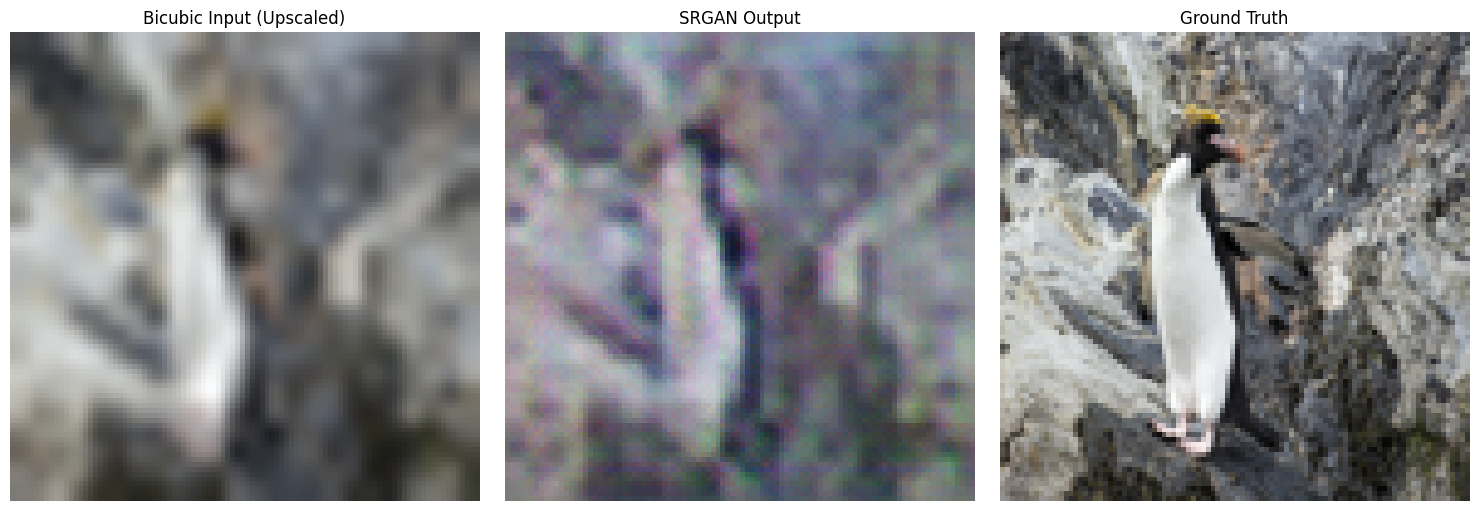

=== Evaluation Results ===
SRGAN vs Ground Truth:
  PSNR: 18.13 dB
  SSIM: 0.4665

Bicubic vs Ground Truth:
  PSNR: 20.43 dB
  SSIM: 0.5138

Improvement:
  PSNR: +-2.30 dB
  SSIM: +-0.0473

Evaluation complete. Results saved in the 'results' folder.


In [ ]:
# Load a test image
test_image_path = f"{TEST_DIR}/0801.png" # Example image
image = Image.open(test_image_path).convert("RGB")

# Prepare HR ground truth (crop to match output size)
hr_transform = transforms.Compose([
    transforms.Resize((HIGH_RES_SIZE, HIGH_RES_SIZE), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
hr_image = hr_transform(image).unsqueeze(0).to(DEVICE)

# Prepare LR image
lr_transform = transforms.Compose([
    transforms.Resize((LOW_RES_SIZE, LOW_RES_SIZE), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
])
lr_image = lr_transform(image).unsqueeze(0).to(DEVICE)

# Load generator
gen = Generator().to(DEVICE)
gen.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
gen.eval()

with torch.no_grad():
    sr_image = gen(lr_image)

# Save the results
os.makedirs("results", exist_ok=True)
save_image(sr_image * 0.5 + 0.5, "results/sr_result_1.png")
save_image(hr_image * 0.5 + 0.5, "results/hr_ground_truth_1.png")

# Create bicubic upscaled version for comparison
bicubic_image = lr_image.squeeze(0).cpu().detach()
# Denormalize LR image from [0, 1] to [0, 255]
bicubic_image = (bicubic_image * 255).clamp(0, 255).byte()
bicubic_transform = transforms.ToPILImage()
bicubic_pil = bicubic_transform(bicubic_image)
bicubic_pil = bicubic_pil.resize((HIGH_RES_SIZE, HIGH_RES_SIZE), Image.BICUBIC)
bicubic_pil.save("results/bicubic_result_1.png")

# Convert tensors to images for display
sr_display_img = transforms.ToPILImage()((sr_image.cpu().squeeze(0) * 0.5 + 0.5).clamp(0, 1))
hr_display_img = transforms.ToPILImage()((hr_image.cpu().squeeze(0) * 0.5 + 0.5).clamp(0, 1))

# Display comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Bicubic Input (Upscaled)")
plt.imshow(bicubic_pil)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("SRGAN Output")
plt.imshow(sr_display_img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(hr_display_img)
plt.axis('off')

plt.tight_layout()
plt.show()

# Convert images to numpy arrays for metric calculation
sr_numpy = tensor_to_numpy(sr_image)
hr_numpy = tensor_to_numpy(hr_image)
bicubic_numpy = np.array(bicubic_pil)

sr_psnr, sr_ssim = calculate_metrics_paper_protocol(original_numpy, sr_numpy)
bicubic_psnr, bicubic_ssim = calculate_metrics_paper_protocol(original_numpy, bicubic_numpy)

print("=== Evaluation Results ===")
print(f"SRGAN vs Ground Truth:")
print(f"  PSNR: {sr_psnr:.2f} dB")
print(f"  SSIM: {sr_ssim:.4f}")
print(f"\nBicubic vs Ground Truth:")
print(f"  PSNR: {bicubic_psnr:.2f} dB")
print(f"  SSIM: {bicubic_ssim:.4f}")
print(f"\nImprovement:")
print(f"  PSNR: +{sr_psnr - bicubic_psnr:.2f} dB")
print(f"  SSIM: +{sr_ssim - bicubic_ssim:.4f}")

print("\nEvaluation complete. Results saved in the 'results' folder.")

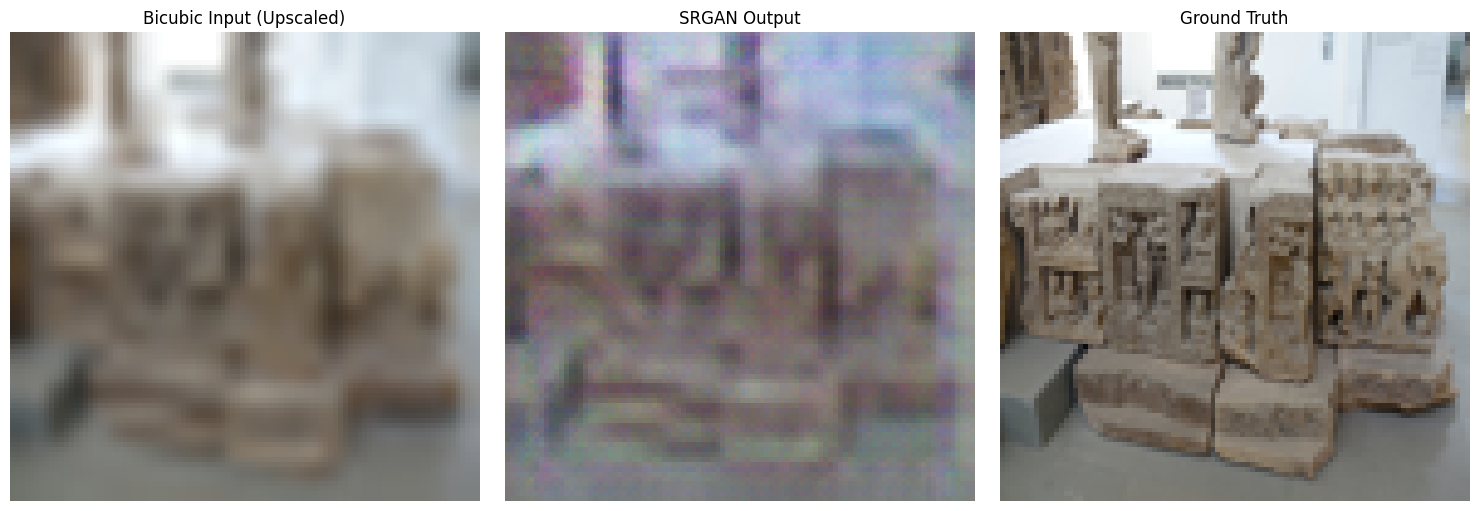

=== Evaluation Results ===
SRGAN vs Ground Truth:
  PSNR: 18.88 dB
  SSIM: 0.5616

Bicubic vs Ground Truth:
  PSNR: 23.22 dB
  SSIM: 0.6125

Improvement:
  PSNR: +-4.34 dB
  SSIM: +-0.0508

Evaluation complete. Results saved in the 'results' folder.


In [ ]:
# Load a test image
test_image_path = f"{TEST_DIR}/0816.png" # Example image
image = Image.open(test_image_path).convert("RGB")

# Prepare HR ground truth (crop to match output size)
hr_transform = transforms.Compose([
    transforms.Resize((HIGH_RES_SIZE, HIGH_RES_SIZE), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
hr_image = hr_transform(image).unsqueeze(0).to(DEVICE)

# Prepare LR image
lr_transform = transforms.Compose([
    transforms.Resize((LOW_RES_SIZE, LOW_RES_SIZE), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
])
lr_image = lr_transform(image).unsqueeze(0).to(DEVICE)

# Load generator
gen = Generator().to(DEVICE)
gen.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
gen.eval()

with torch.no_grad():
    sr_image = gen(lr_image)

# Save the results
os.makedirs("results", exist_ok=True)
save_image(sr_image * 0.5 + 0.5, "results/sr_result_2.png")
save_image(hr_image * 0.5 + 0.5, "results/hr_ground_truth_2.png")

# Create bicubic upscaled version for comparison
bicubic_image = lr_image.squeeze(0).cpu().detach()
# Denormalize LR image from [0, 1] to [0, 255]
bicubic_image = (bicubic_image * 255).clamp(0, 255).byte()
bicubic_transform = transforms.ToPILImage()
bicubic_pil = bicubic_transform(bicubic_image)
bicubic_pil = bicubic_pil.resize((HIGH_RES_SIZE, HIGH_RES_SIZE), Image.BICUBIC)
bicubic_pil.save("results/bicubic_result_2.png")

# Convert tensors to images for display
sr_display_img = transforms.ToPILImage()((sr_image.cpu().squeeze(0) * 0.5 + 0.5).clamp(0, 1))
hr_display_img = transforms.ToPILImage()((hr_image.cpu().squeeze(0) * 0.5 + 0.5).clamp(0, 1))

# Display comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Bicubic Input (Upscaled)")
plt.imshow(bicubic_pil)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("SRGAN Output")
plt.imshow(sr_display_img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(hr_display_img)
plt.axis('off')

plt.tight_layout()
plt.show()

# Convert images to numpy arrays for metric calculation
sr_numpy = tensor_to_numpy(sr_image)
hr_numpy = tensor_to_numpy(hr_image)
bicubic_numpy = np.array(bicubic_pil)

sr_psnr, sr_ssim = calculate_metrics_paper_protocol(original_numpy, sr_numpy)
bicubic_psnr, bicubic_ssim = calculate_metrics_paper_protocol(original_numpy, bicubic_numpy)

print("=== Evaluation Results ===")
print(f"SRGAN vs Ground Truth:")
print(f"  PSNR: {sr_psnr:.2f} dB")
print(f"  SSIM: {sr_ssim:.4f}")
print(f"\nBicubic vs Ground Truth:")
print(f"  PSNR: {bicubic_psnr:.2f} dB")
print(f"  SSIM: {bicubic_ssim:.4f}")
print(f"\nImprovement:")
print(f"  PSNR: +{sr_psnr - bicubic_psnr:.2f} dB")
print(f"  SSIM: +{sr_ssim - bicubic_ssim:.4f}")

print("\nEvaluation complete. Results saved in the 'results' folder.")

In [ ]:
# Create test dataset
test_dataset = ImageDataset(hr_dir=TEST_DIR, hr_size=HIGH_RES_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

# Load generator
gen = Generator().to(DEVICE)
gen.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
gen.eval()

total_sr_psnr = 0
total_sr_ssim = 0
total_bicubic_psnr = 0
total_bicubic_ssim = 0
num_images = 0

print("Evaluating on test dataset...")

with torch.no_grad():
    for i, (lr, hr) in enumerate(test_loader):
        lr = lr.to(DEVICE)
        hr = hr.to(DEVICE)

        # Generate SR image
        sr = gen(lr)

        # Convert to numpy arrays
        sr_numpy = tensor_to_numpy(sr)
        hr_numpy = tensor_to_numpy(hr)

        # Create bicubic baseline
        lr_numpy = tensor_to_numpy(lr)
        bicubic_pil = Image.fromarray(lr_numpy).resize((HIGH_RES_SIZE, HIGH_RES_SIZE), Image.BICUBIC)
        bicubic_numpy = np.array(bicubic_pil)

        # Calculate metrics
        sr_psnr, sr_ssim = calculate_metrics_paper_protocol(original_numpy, sr_numpy)
        bicubic_psnr, bicubic_ssim = calculate_metrics_paper_protocol(original_numpy, bicubic_numpy)

        total_sr_psnr += sr_psnr
        total_sr_ssim += sr_ssim
        total_bicubic_psnr += bicubic_psnr
        total_bicubic_ssim += bicubic_ssim
        num_images += 1

        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1} images...")

# Calculate averages
avg_sr_psnr = total_sr_psnr / num_images
avg_sr_ssim = total_sr_ssim / num_images
avg_bicubic_psnr = total_bicubic_psnr / num_images
avg_bicubic_ssim = total_bicubic_ssim / num_images

print(f"\n=== Average Results on {num_images} Test Images ===")
print(f"SRGAN:")
print(f"  Average PSNR: {avg_sr_psnr:.2f} dB")
print(f"  Average SSIM: {avg_sr_ssim:.4f}")
print(f"\nBicubic Baseline:")
print(f"  Average PSNR: {avg_bicubic_psnr:.2f} dB")
print(f"  Average SSIM: {avg_bicubic_ssim:.4f}")
print(f"\nAverage Improvement:")
print(f"  PSNR: +{avg_sr_psnr - avg_bicubic_psnr:.2f} dB")
print(f"  SSIM: +{avg_sr_ssim - avg_bicubic_ssim:.4f}")

Evaluating on test dataset...
Processed 10 images...
Processed 20 images...
Processed 30 images...
Processed 40 images...
Processed 50 images...
Processed 60 images...
Processed 70 images...
Processed 80 images...
Processed 90 images...
Processed 100 images...

=== Average Results on 100 Test Images ===
SRGAN:
  Average PSNR: 17.54 dB
  Average SSIM: 0.6241

Bicubic Baseline:
  Average PSNR: 10.56 dB
  Average SSIM: 0.5042

Average Improvement:
  PSNR: +6.98 dB
  SSIM: +0.1200


## Huggingface.py

In [21]:
from huggingface_hub import HfApi, login
import json

# Login to Hugging Face
login()

In [22]:
# Create a new repository
api = HfApi()
api.create_repo(repo_id=model_name, repo_type="model", exist_ok=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RepoUrl('https://huggingface.co/keanteng/srgan-div2k-0723', endpoint='https://huggingface.co', repo_type='model', repo_id='keanteng/srgan-div2k-0723')

In [23]:
# Push the model to Hugging Face Hub
api = HfApi()
api.upload_folder(
    folder_path=f"saved_models",
    repo_id=model_name,
    repo_type="model"
)

Uploading...:   0%|          | 0.00/33.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/keanteng/srgan-div2k-0723/commit/2addc74ad1b88b630880616f1031b79ba31e060a', commit_message='Upload folder using huggingface_hub', commit_description='', oid='2addc74ad1b88b630880616f1031b79ba31e060a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/keanteng/srgan-div2k-0723', endpoint='https://huggingface.co', repo_type='model', repo_id='keanteng/srgan-div2k-0723'), pr_revision=None, pr_num=None)

In [ ]:
readme_content = f"""
---
license: agpl-3.0
datasets:
- eugenesiow/Div2k
pipeline_tag: super-resolution
library_name: pytorch
tags:
- generative-ai
- deep-cnn
- super-resolution
---

> For this version, the model has been trained for 50 epochs on the SRResNet pre-training phase and 100 epochs on the GAN training phase. Since purple tint is observed when trained for 15 epochs, this version is trained for longer to check if the issue persists.

# SRGAN Model for Super-Resolution

This repository contains a Super-Resolution Generative Adversarial Network (SRGAN) model trained on the DIV2K dataset. The model is designed to enhance the resolution of low-resolution images using deep convolutional neural networks.

## Experiment Implementation

The results as follows:

- **PSNR**: {avg_sr_psnr:.2f} dB
- **SSIM**: {avg_sr_ssim:.4f}

"""

In [25]:
# Save README
with open("README.md", "w") as f:
    f.write(readme_content)

# Upload README to Hugging Face Hub
api.upload_file(
    path_or_fileobj=f"README.md",
    path_in_repo="README.md",
    repo_id=model_name,
    repo_type="model"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9692: UserWarning: Warnings while validating metadata in README.md:
- The pipeline tag "super-resolution" is not in the official list: text-classification, token-classification, table-question-answering, question-answering, zero-shot-classification, translation, summarization, feature-extraction, text-generation, fill-mask, sentence-similarity, text-to-speech, text-to-audio, automatic-speech-recognition, audio-to-audio, audio-classification, audio-text-to-text, voice-activity-detection, depth-estimation, image-classification, object-detection, image-segmentation, text-to-image, image-to-text, image-to-image, image-to-video, unconditional-image-generation, video-classification, reinforcement-learning, robotics, tabular-classification, tabular-regression, tabular-to-text, table-to-text, multiple-choice, text-ranking, text-retrieval, time-series-forecasting, text-to-video, image-text-to-text, visual-question-answering, docu

CommitInfo(commit_url='https://huggingface.co/keanteng/srgan-div2k-0723/commit/f5d6da050f19e38ee2b12396b333ea4901929d8c', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='f5d6da050f19e38ee2b12396b333ea4901929d8c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/keanteng/srgan-div2k-0723', endpoint='https://huggingface.co', repo_type='model', repo_id='keanteng/srgan-div2k-0723'), pr_revision=None, pr_num=None)

In [26]:
api.upload_folder(
    folder_path=f"results",
    repo_id=f"{model_name}",
    repo_type="model",
    path_in_repo="results"
)

CommitInfo(commit_url='https://huggingface.co/keanteng/srgan-div2k-0723/commit/4b9823f74ee5b959a9b8157c379db5f68e63e33c', commit_message='Upload folder using huggingface_hub', commit_description='', oid='4b9823f74ee5b959a9b8157c379db5f68e63e33c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/keanteng/srgan-div2k-0723', endpoint='https://huggingface.co', repo_type='model', repo_id='keanteng/srgan-div2k-0723'), pr_revision=None, pr_num=None)